# Counting and Classification

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import pymc3 as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import theano
import arviz as az

import warnings
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
warnings.simplefilter(action="ignore", category=FutureWarning)

### Binomial Regression

##### Code 10.1

In [2]:
d = pd.read_csv("../../data/chimpanzees.csv", sep=";")

# Change actor to be zero-indexed
d.actor -= 1

##### Code 10.2

In [3]:
with pm.Model() as m10_1:
    a = pm.Normal("a", mu=0, sd=10)
    p = pm.math.invlogit(a)
    pulled_left = pm.Binomial("pulled_left", n=1, p=p, observed=d.pulled_left)
    trace_m10_1 = pm.sample(1000, tune=1000)

az.summary(trace_m10_1, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3006.75draws/s]


,mean,sd,hpd_3%,hpd_97%
a,0.32,0.092,0.161,0.508


##### Code 10.3

In [4]:
logistic = lambda x: np.exp(x) / (np.exp(x) + 1)

logistic([0.18, 0.46])

array([0.54487889, 0.61301418])

##### Code 10.4

In [5]:
with pm.Model() as m10_2:
    a = pm.Normal("a", mu=0, sd=10)
    bp = pm.Normal("bp", mu=0, sd=10)
    p = pm.math.invlogit(a + bp * d.prosoc_left)
    pulled_left = pm.Binomial("pulled_left", n=1, p=p, observed=d.pulled_left)
    trace_m10_2 = pm.sample(1000, tune=1000)
    
with pm.Model() as m10_3:
    a = pm.Normal("a", mu=0, sd=10)
    bp = pm.Normal("bp", mu=0, sd=10)
    bpC = pm.Normal("bpC", mu=0, sd=10)
    p = pm.math.invlogit(a + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial("pulled_left", n=1, p=p, observed=d.pulled_left)
    trace_m10_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bp, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1217.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 880.51draws/s] 


##### Code 10.5

In [6]:
comp_df = az.compare({f"m10_{i}": eval(f"trace_m10_{i}") for i in [1,2,3]} , method='pseudo-BMA')
comp_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m10_2,0,680.429,1.96628,0,0.68733,9.35843,0,False,deviance
m10_3,1,682.106,2.88198,1.67732,0.297126,9.4493,0.861831,False,deviance
m10_1,2,688.007,1.03357,7.57829,0.0155439,7.10704,6.21549,False,deviance


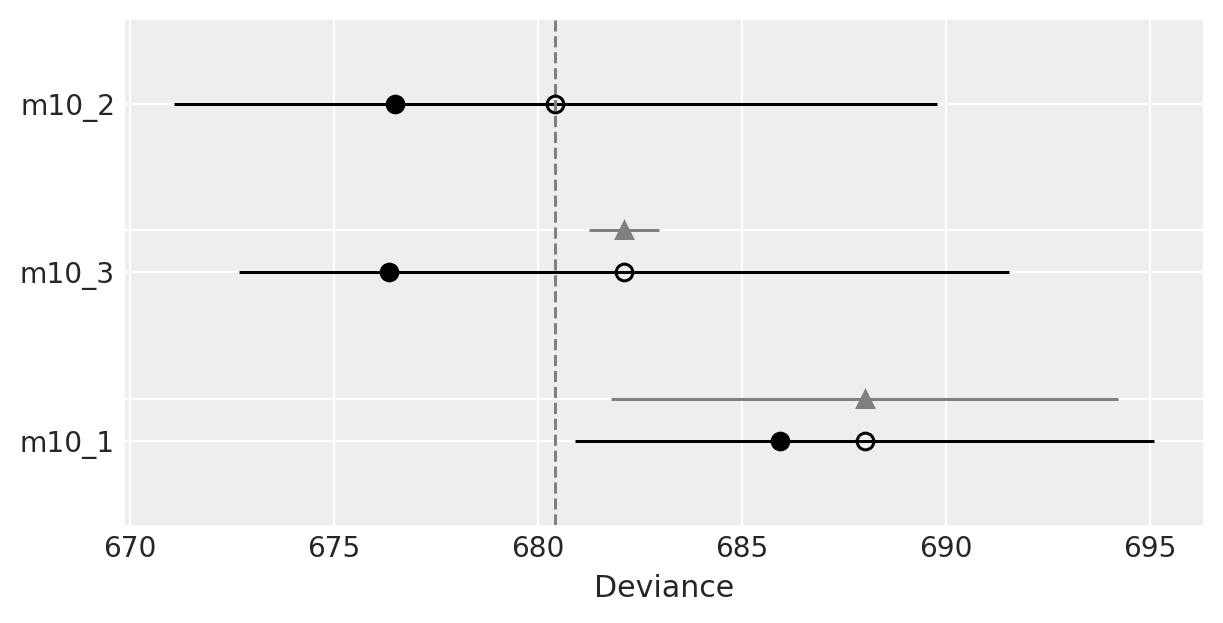

In [7]:
az.plot_compare(comp_df);

##### Code 10.6

In [8]:
az.summary(trace_m10_3, kind="stats", credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.042,0.123,-0.156,0.229
bp,0.626,0.221,0.246,0.957
bpC,-0.111,0.262,-0.512,0.327


##### Code 10.7

In [9]:
np.exp(0.61)

1.8404313987816374

##### Code 10.8

In [10]:
logistic(4)

0.9820137900379085

###### Code 10.9

In [11]:
logistic(4 + 0.61)

0.9901462444767687

##### Code 10.10

In [12]:
d_pred = pd.DataFrame({"prosoc_left": [0,1,0,1], "condition": [0,0,1,1]})
traces = [eval(f"trace_m10_{i+1}") for i in range(3)]
models = [eval(f"m10_{i+1}") for i in range(3)]

chimp_ensemble = pm.sample_posterior_predictive_w(traces=traces, samples=1000, models=models, weights=comp_df.weight.sort_index(ascending=True))


100%|██████████| 1000/1000 [00:00<00:00, 1043.52it/s]


##### Code 10.11 & Figure 10.2

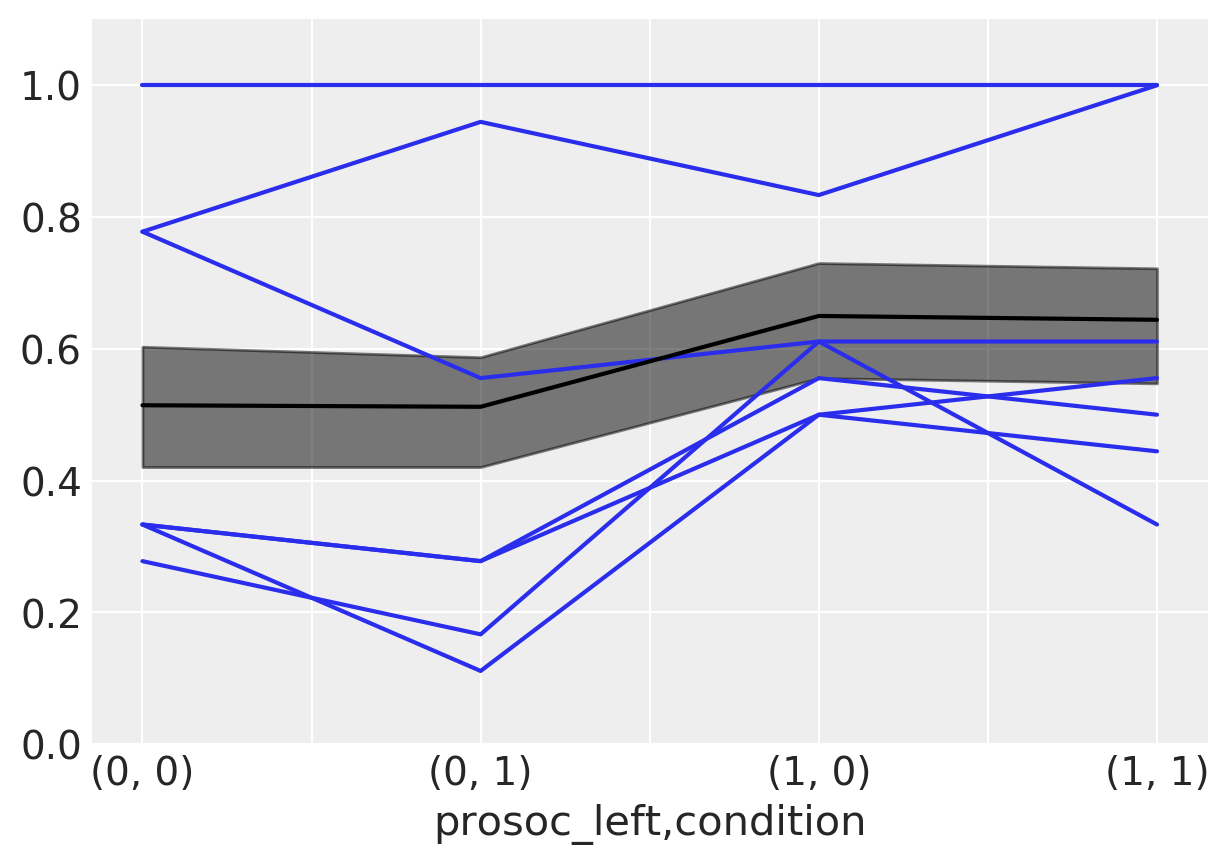

In [13]:
grouping_cols = ["prosoc_left", "condition"]
df = (
    pd.concat([d[grouping_cols], pd.DataFrame(chimp_ensemble["pulled_left"].T)], axis=1)
    .groupby(grouping_cols)
    .mean()
    .reset_index(drop=True)
    .T
)

ticks = range(4)
chimps = (
    d
    .groupby(['actor', 'prosoc_left', 'condition'])
    .pulled_left.mean()
    .reset_index()
    .pivot_table(values="pulled_left", index=["prosoc_left", "condition"], columns="actor")
)
# Plot individual line for each chimp
chimps.plot(style="C0", legend=False)
# Plot shaded area of posterior predictive
az.plot_hpd(ticks, df, color='k', smooth=False, credible_interval=0.89)
df.mean().plot(color='k')
plt.ylim(0, 1.1);

##### Code 10.12

In [14]:
# This is same as 10.4 exacpt the book uses stan
d2 = d.copy(deep=True).drop(columns=["recipient"])

with pm.Model() as m10_3s:
    a = pm.Normal("a", mu=0, sd=10)
    bp = pm.Normal("bp", mu=0, sd=10)
    bpC = pm.Normal("bpC", mu=0, sd=10)
    p = pm.math.invlogit(a + (bp + bpC * d2.condition) * d2.prosoc_left)
    pulled_left = pm.Binomial("pulled_left", n=1, p=p, observed=d2.pulled_left)
    trace_m10_3s = pm.sample(1000, tune=1000)

az.summary(trace_m10_3s, kind="stats", credible_interval=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1101.84draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
a,0.049,0.125,-0.162,0.231
bp,0.623,0.233,0.283,1.034
bpC,-0.118,0.268,-0.530,0.326


##### Code 10.13

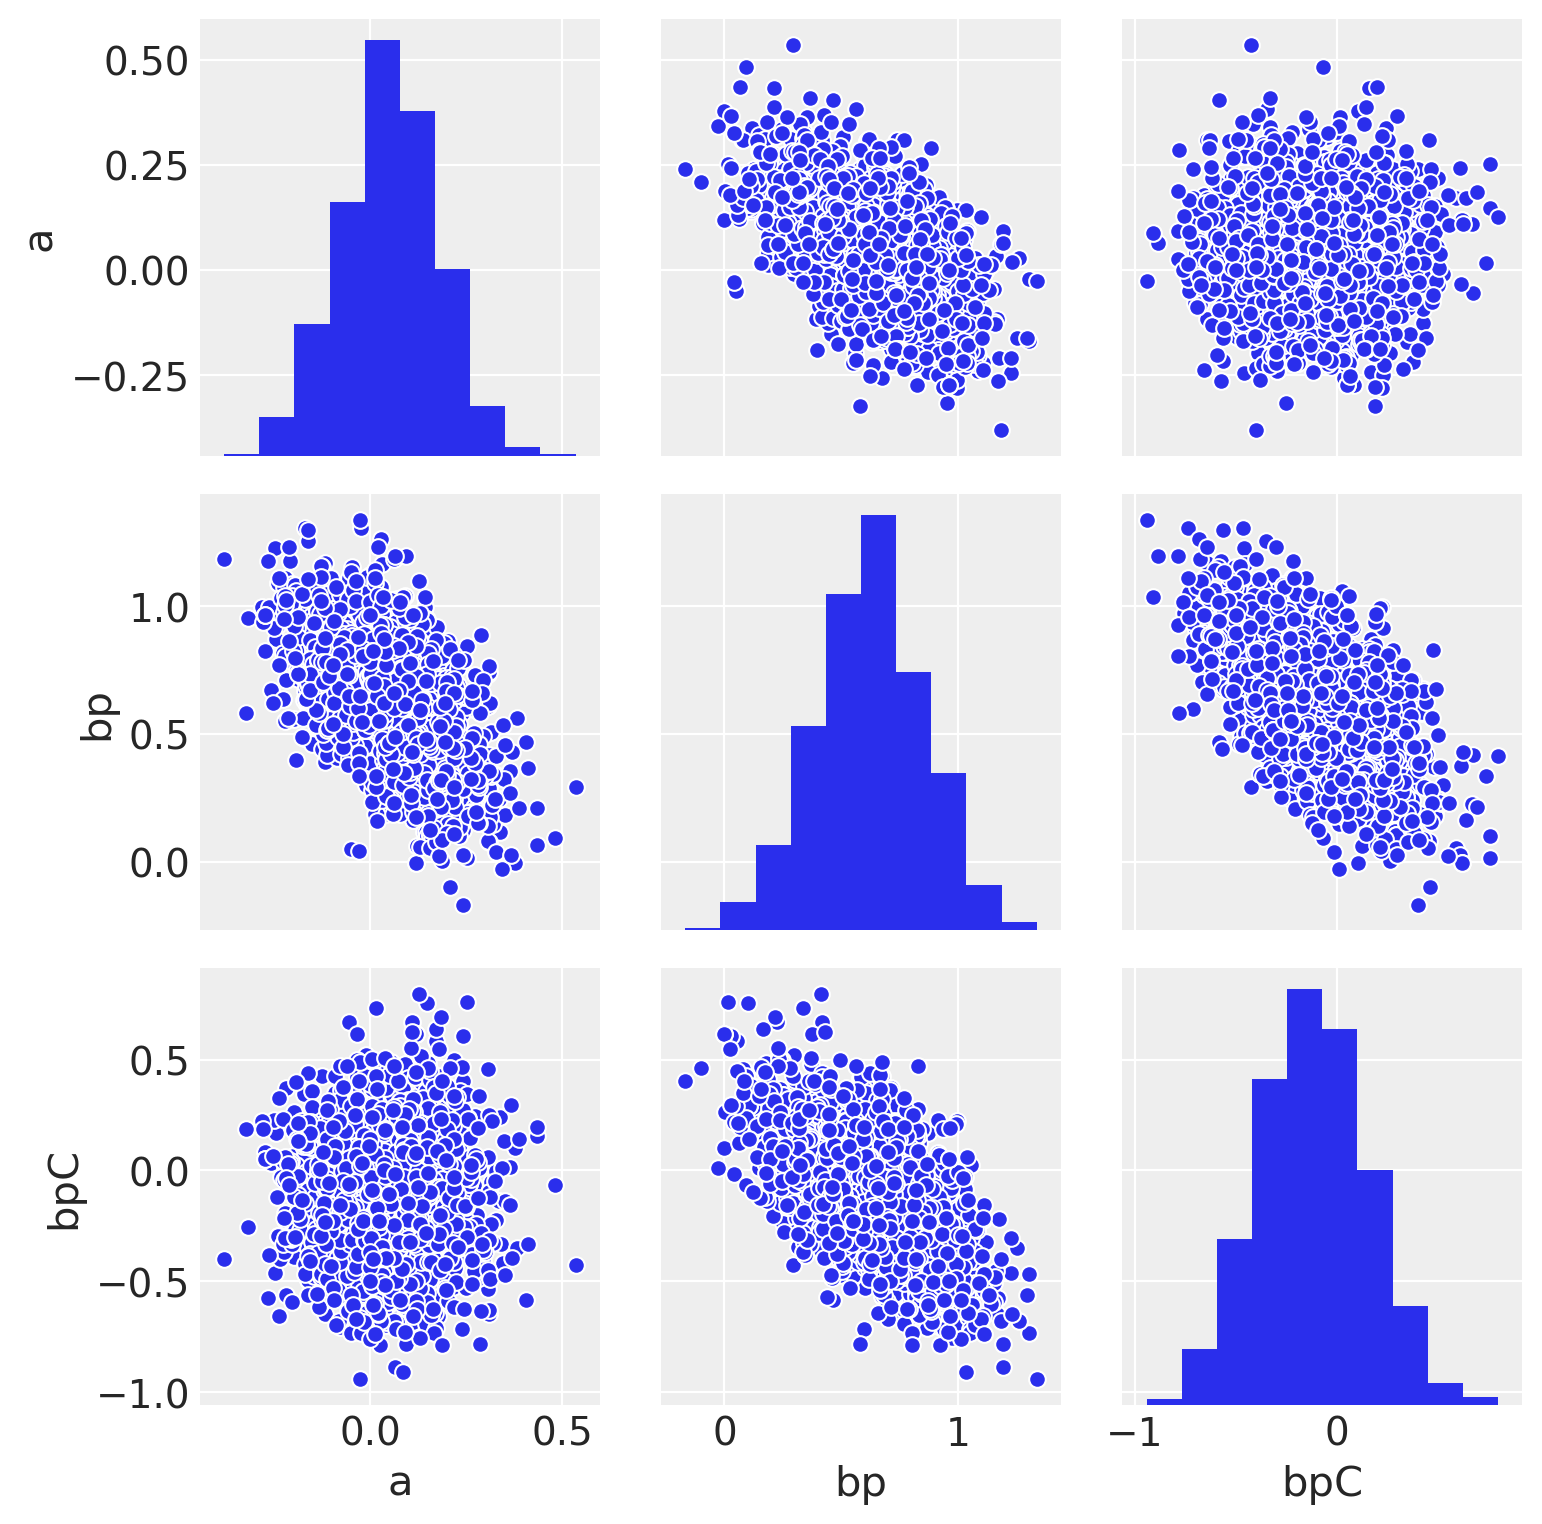

In [15]:
m10_3s_df = pm.trace_to_dataframe(trace_m10_3s)
sns.pairplot(m10_3s_df);

##### Code 10.14

In [16]:
with pm.Model() as m10_4:
    a = pm.Normal("a", mu=0, sd=10, shape=d.actor.nunique())
    bp = pm.Normal("bp", mu=0, sd=10)
    bpC = pm.Normal("bpC", mu=0, sd=10)
    p = pm.math.invlogit(a[d.actor] + (bp + bpC * d2.condition) * d2.prosoc_left)
    pulled_left = pm.Binomial("pulled_left", n=1, p=p, observed=d2.pulled_left)
    trace_m10_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, a]
Sampling 2 chains, 6 divergences: 100%|██████████| 4000/4000 [00:07<00:00, 544.65draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


##### Code 10.15

In [17]:
d.actor.unique()

array([0, 1, 2, 3, 4, 5, 6])

##### Code 10.16

In [18]:
az.summary(trace_m10_4, kind='stats', credible_interval=0.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%
a[0],-0.75,0.28,-1.17,-0.30
a[1],10.82,5.21,3.12,17.71
a[2],-1.07,0.28,-1.52,-0.65
a[3],-1.05,0.27,-1.50,-0.63
a[4],-0.75,0.28,-1.22,-0.35
a[5],0.22,0.26,-0.19,0.63
a[6],1.80,0.40,1.16,2.44
bp,0.85,0.26,0.46,1.29
bpC,-0.14,0.30,-0.65,0.30


##### Code 10.17

In [19]:
post = pm.trace_to_dataframe(trace_m10_4)
post.head()

,a__0,a__1,a__2,a__3,a__4,a__5,a__6,bp,bpC
0,-0.866004,7.917090,-1.201726,-1.107652,-0.606290,0.194704,1.985222,0.516417,0.383029
1,-0.659717,9.187829,-0.835775,-0.774556,-1.135470,0.513137,1.732319,1.032741,-0.533780
2,-0.533962,8.408761,-1.257360,-0.830310,-0.936999,0.037226,2.413675,0.680426,0.083749
3,-0.993973,8.677823,-0.818940,-1.555762,-0.826405,0.242370,1.873087,0.681782,0.124702
4,-1.104870,6.321104,-1.376683,-0.995872,-1.247953,-0.246068,2.357678,1.331498,-0.259041


##### Code 10.18

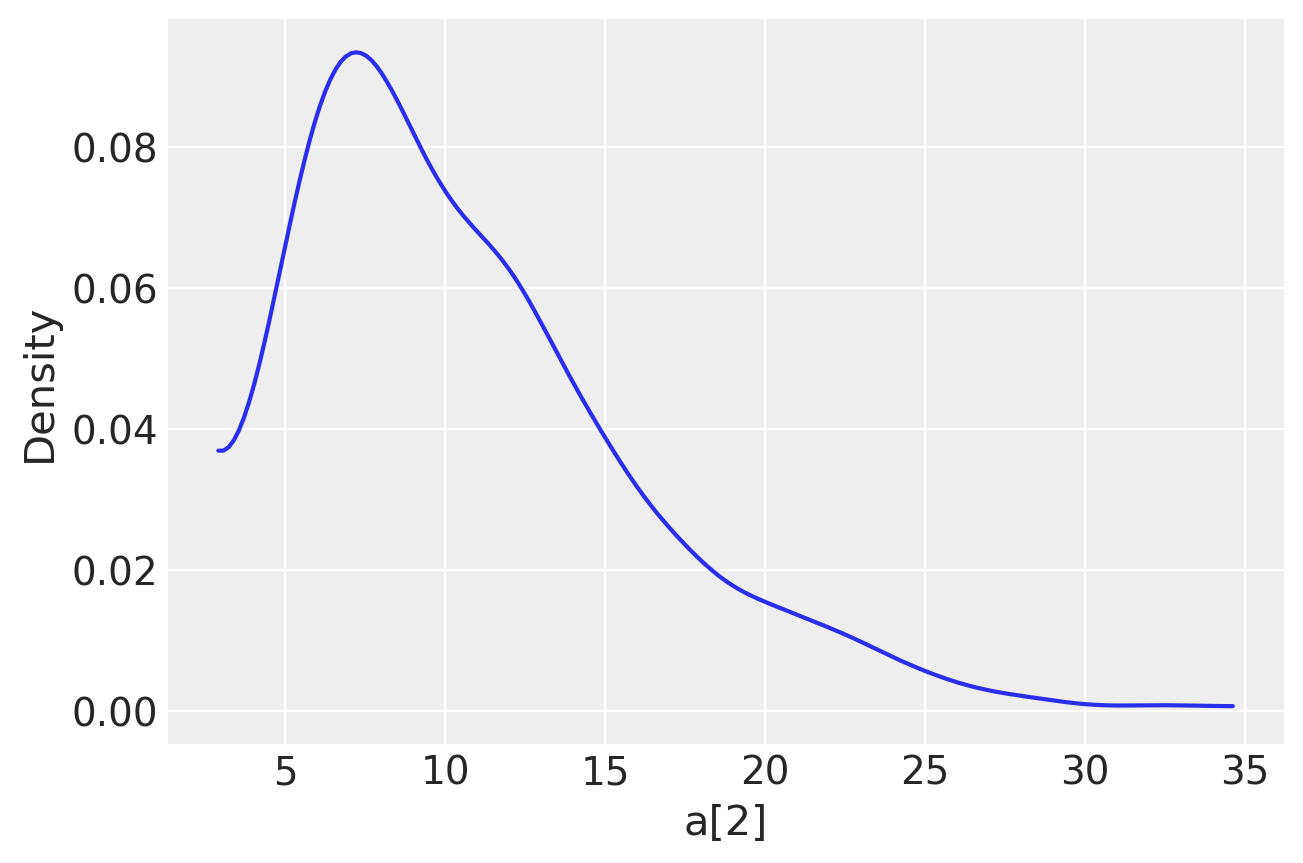

In [20]:
az.plot_kde(post['a__1'])
plt.xlabel('a[2]')
plt.ylabel('Density');

##### Code 10.19

/Users/hamzaiqb/.pyenv/versions/miniconda3-4.3.30/envs/statrethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 1147.44it/s]


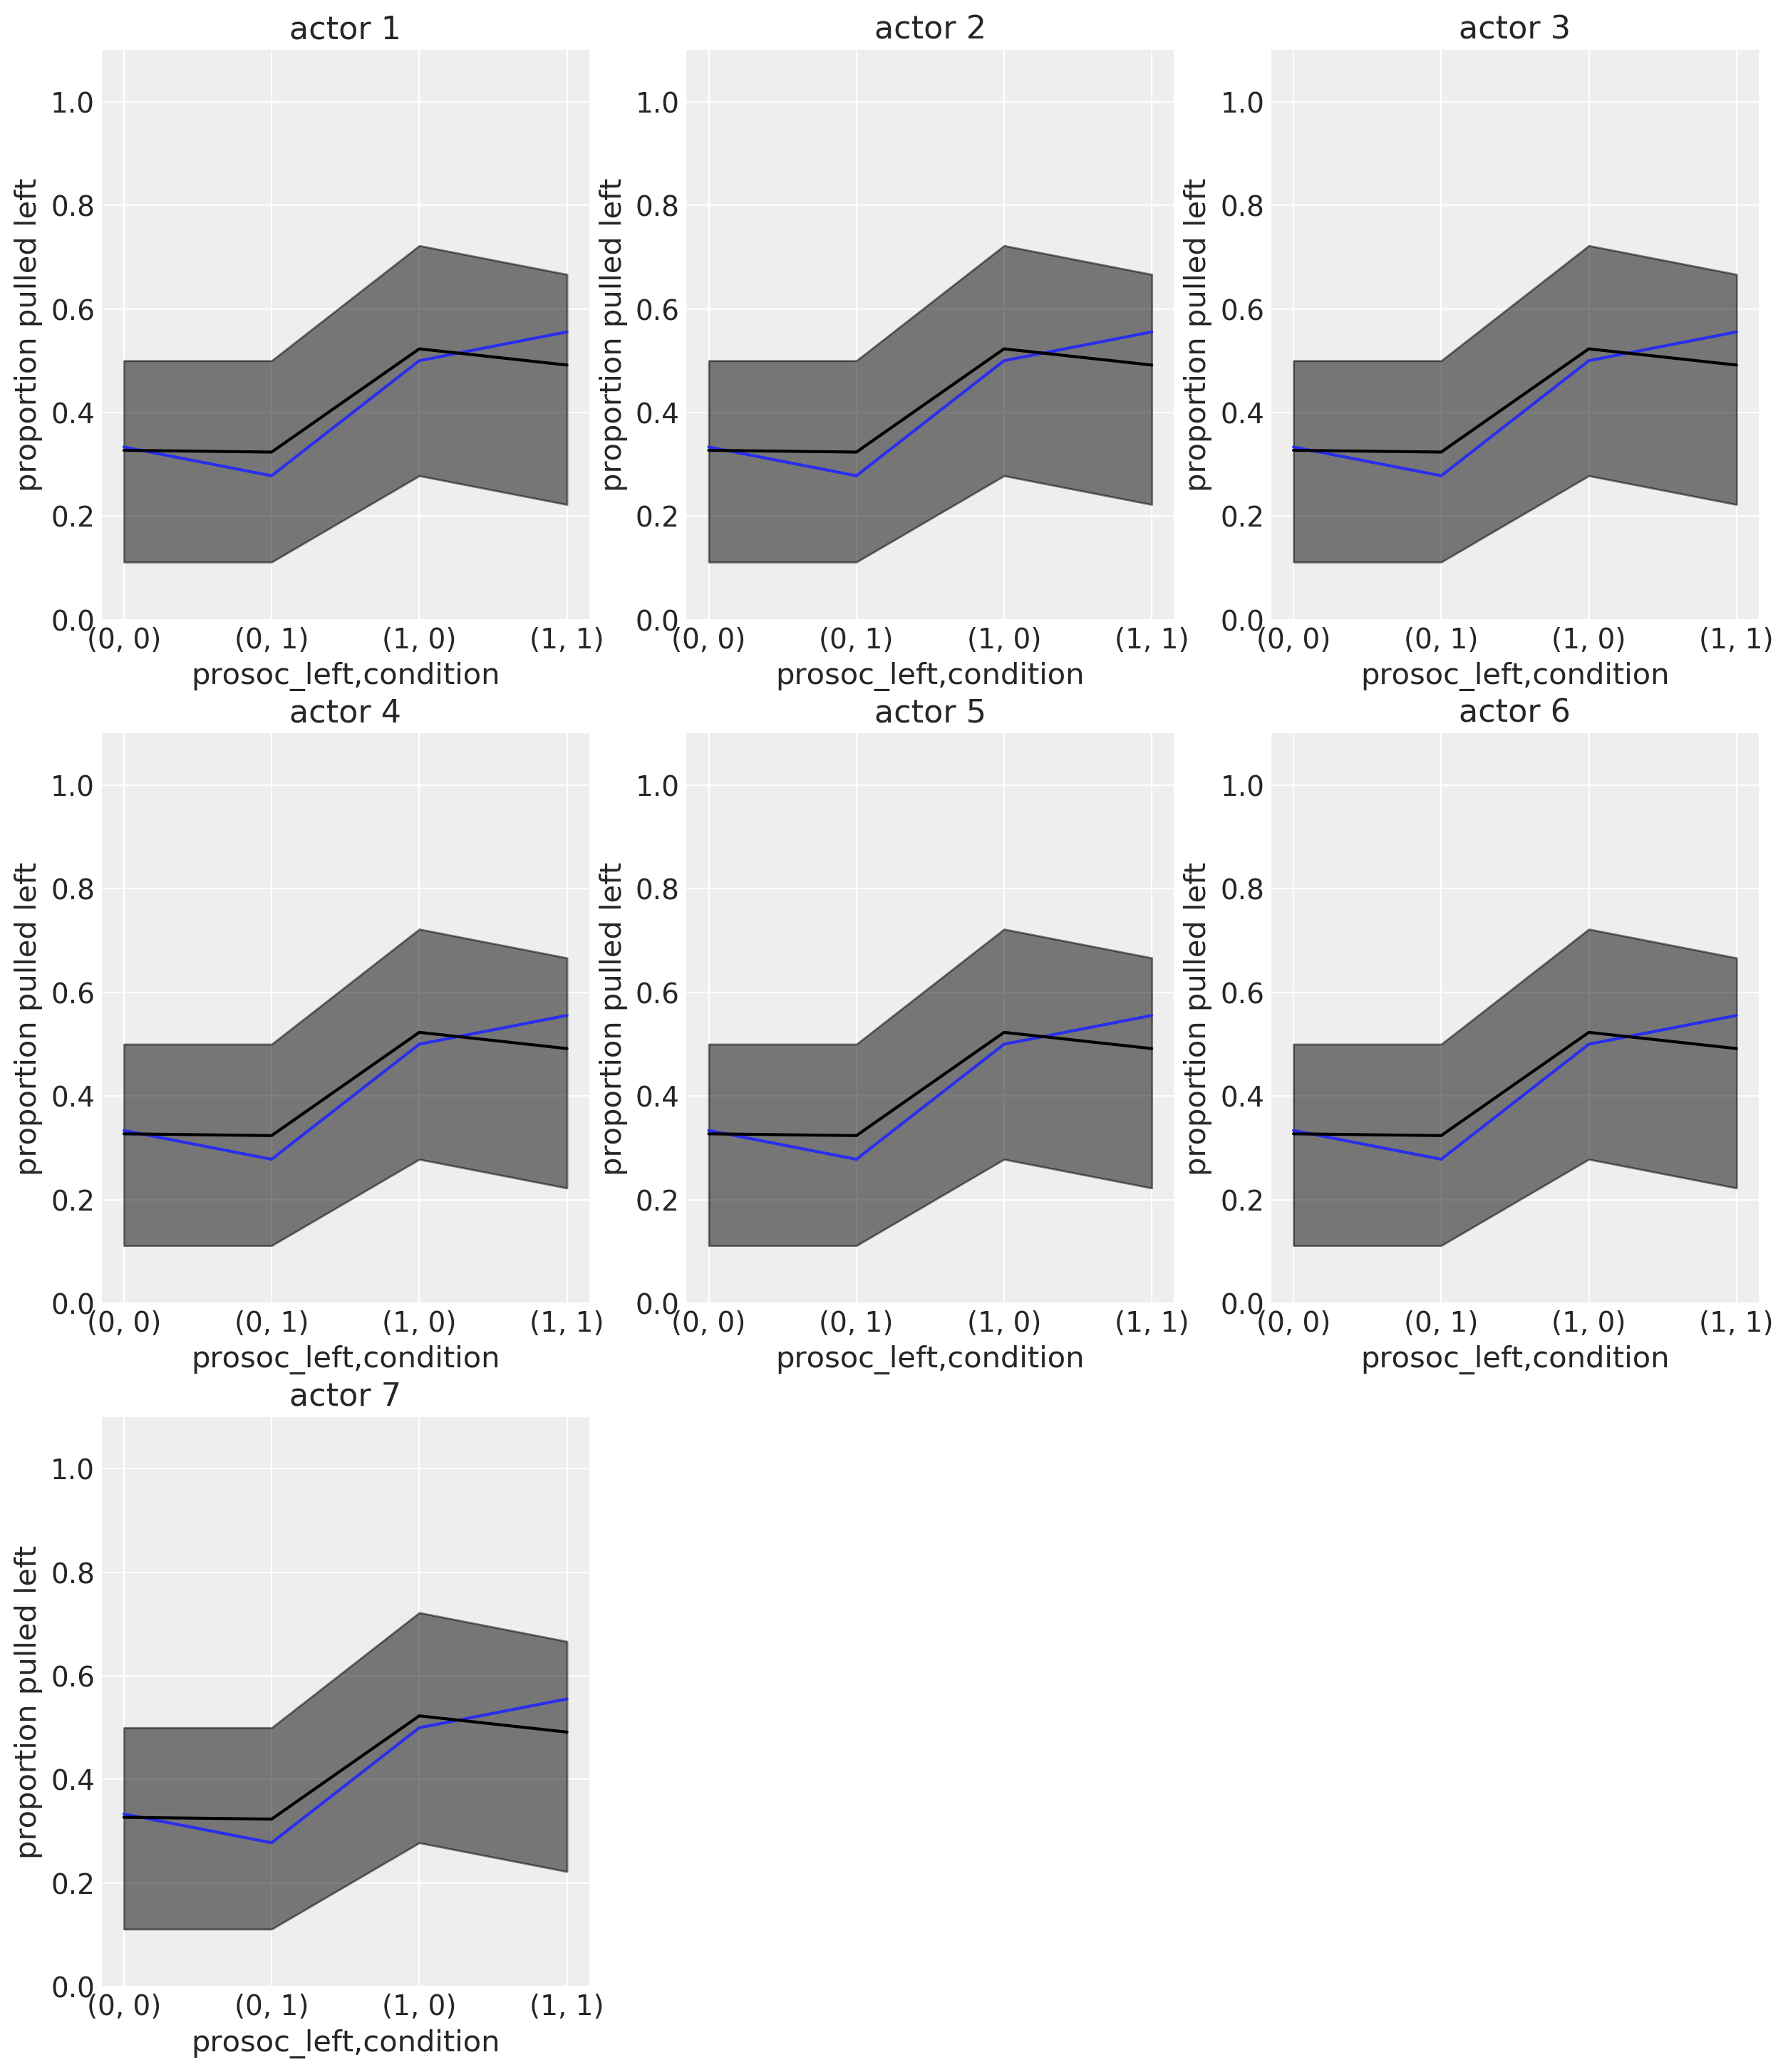

In [21]:
d_pred = pd.DataFrame({"prosoc_left": [0,1,0,1], "condition": [0,0,1,1]})
chimp_s = pm.sample_posterior_predictive(trace_m10_4, 1000, model=m10_4)["pulled_left"]

grouping_cols = ["actor","prosoc_left", "condition"]
df = (
    pd.concat([d[grouping_cols], pd.DataFrame(chimp_s.T)], axis=1)
    .groupby(grouping_cols)
    .mean()
)

ticks = range(4)
chimps = (
    d
    .groupby(['actor', 'prosoc_left', 'condition'])
    .pulled_left.mean()
    .reset_index()
    .pivot_table(values="pulled_left", index=["prosoc_left", "condition"], columns="actor")
)

fig, axes = plt.subplots(3, 3, figsize=(15,18))
for i, ax in enumerate(axes.ravel()):
    if i > d.actor.nunique() - 1:
        fig.delaxes(ax)
        continue
    # Plot individual line for each chimp
    chimps.plot(y=[0], style="C0", legend=False, ax=ax)
    # Plot shaded area of posterior predictive
    pred_mean = df.xs(0, level="actor").reset_index(drop=True).T
    az.plot_hpd(ticks, pred_mean, color='k', smooth=False, credible_interval=0.89, ax=ax)
    pred_mean.mean().plot(color='k', ax=ax)
    
    ax.set_ylim(0, 1.1)
    ax.set_title(f"actor {i+1}")
    ax.set_ylabel("proportion pulled left");

##### Code 10.20

In [22]:
d = pd.read_csv("../../data/chimpanzees.csv", sep=";")
d_aggregated = (
    d
    .groupby(["prosoc_left", "condition", "actor"])
    .pulled_left
    .sum()
    .reset_index()
)

d_aggregated.head(10)

,prosoc_left,condition,actor,pulled_left
0,0,0,1,6
1,0,0,2,18
2,0,0,3,5
3,0,0,4,6
4,0,0,5,6
5,0,0,6,14
6,0,0,7,14
7,0,1,1,5
8,0,1,2,18
9,0,1,3,3


##### Code 10.21

In [23]:
with pm.Model() as m10_5:
    a = pm.Normal('a', mu=0, sd=10)
    bp = pm.Normal('bp', mu=0, sd=10)
    bpC = pm.Normal('bpC', mu=0, sd=10)
    p = pm.math.invlogit(a + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', n=18, p=p, observed=d.pulled_left)
    trace_m10_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1003.53draws/s]


##### Code 10.22

In [24]:
d = pd.read_csv("../../data/UCBadmit.csv", sep=";").reset_index()
d.head()

,index,dept,applicant.gender,admit,reject,applications
0,1,A,male,512,313,825
1,2,A,female,89,19,108
2,3,B,male,353,207,560
3,4,B,female,17,8,25
4,5,C,male,120,205,325


##### Code 10.23

In [25]:
d.male = (d["applicant.gender"] == "male").astype(int)
with pm.Model() as m10_6:
    a = pm.Normal('a', mu=0, sd=10)
    bm = pm.Normal('bm', mu=0, sd=10)
    p = pm.math.invlogit(a + bm * d.male)
    admit = pm.Binomial("admit", n=d.applications, p=p, observed=d.admit)
    trace_m10_6 = pm.sample(1000, tune=1000)
    
with pm.Model() as m10_7:
    a = pm.Normal('a', mu=0, sd=10)
    p = pm.math.invlogit(a)
    admit = pm.Binomial("admit", n=d.applications, p=p, observed=d.admit)
    trace_m10_7 = pm.sample(1000, tune=1000)

/Users/hamzaiqb/.pyenv/versions/miniconda3-4.3.30/envs/statrethinking/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bm, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2402.12draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3714.54draws/s]


##### Code 10.24

In [26]:
az.compare({
    "m10_6": trace_m10_6,
    "m10_7": trace_m10_7,
})

/Users/hamzaiqb/.pyenv/versions/miniconda3-4.3.30/envs/statrethinking/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m10_6,0,996.09,116.566,0,0.632874,322.162,0,True,deviance
m10_7,1,1052.72,84.9824,56.6288,0.367126,315.804,161.025,True,deviance


##### Code 10.25

In [27]:
az.summary(trace_m10_6, credible_interval=0.89, kind='stats', round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%
a,-0.83,0.05,-0.91,-0.75
bm,0.61,0.07,0.50,0.71


##### Code 10.26

In [28]:
post = pm.trace_to_dataframe(trace_m10_6)
p_admit_male = logistic(post.a + post.bm)
p_admit_female = logistic(post.a)
diff_admit = p_admit_male - p_admit_female
diff_admit.describe(percentiles=[0.025, 0.5, 0.975])[['2.5%', '50%', '97.5%']]

2.5%     0.112426
50%      0.141740
97.5%    0.170320
dtype: float64

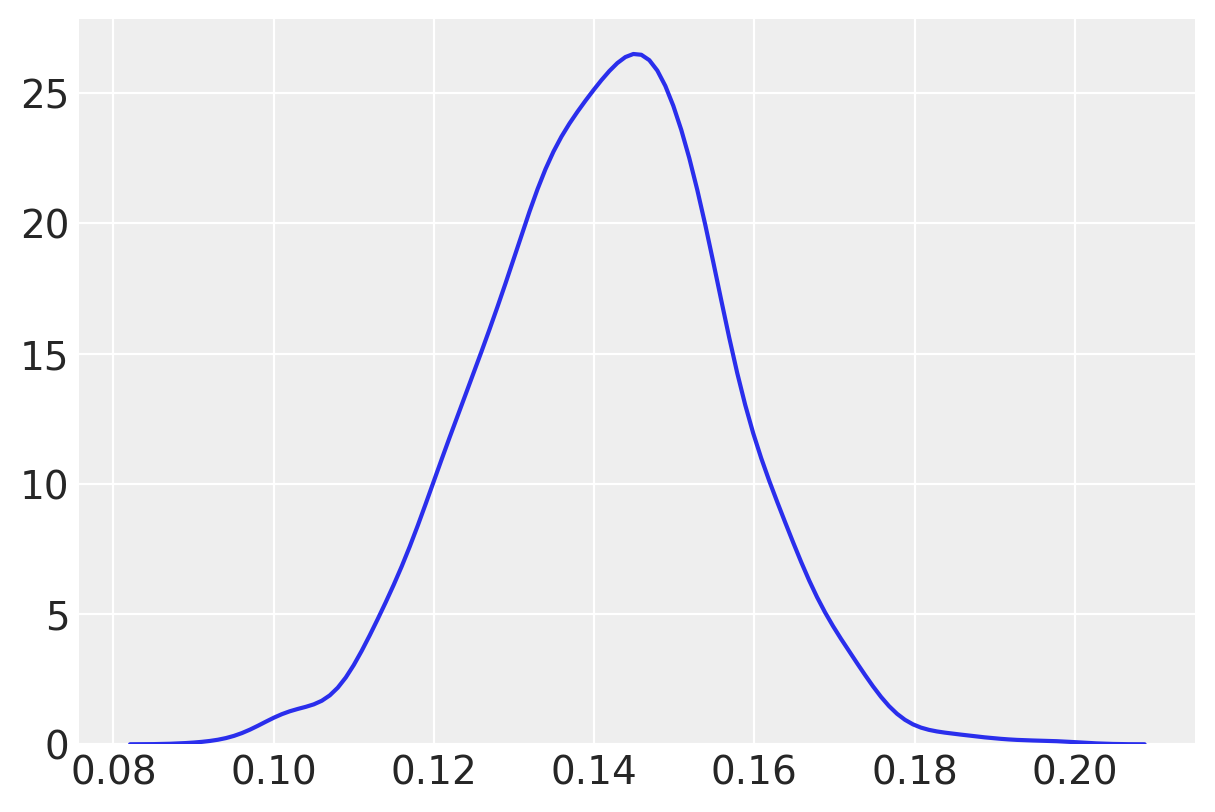

In [29]:
sns.kdeplot(diff_admit);

##### Code 10.27 & Figure 10.5

/Users/hamzaiqb/.pyenv/versions/miniconda3-4.3.30/envs/statrethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 1434.70it/s]


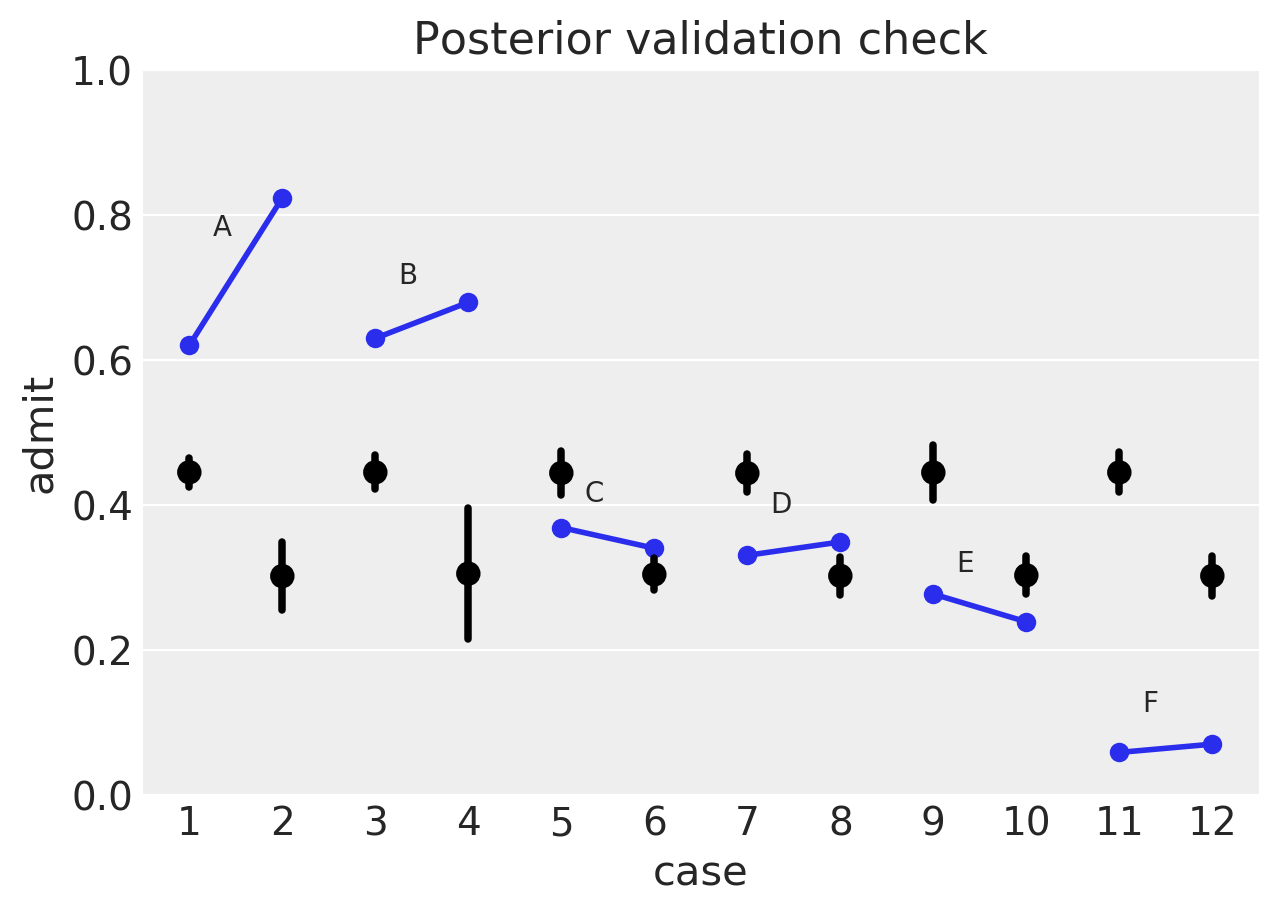

In [30]:
for i in range(6):
    x = 2 * i
    y1 = d.admit[x] / d.applications[x]
    y2 = d.admit[x+1] / d.applications[x+1]
    plt.plot([x, x+1], [y1, y2], '-C0o', lw=2)
    plt.text( x + 0.25, (y1+y2)/2 + 0.05, d.dept[x])


t = pd.DataFrame(pm.sample_posterior_predictive(trace_m10_6, 1000, m10_6)["admit"]).T
x = pd.concat([d, t], axis=1).melt(id_vars=d.columns).assign(value = lambda x: x.value / x.applications)
sns.pointplot(x="index", y="value", data=x, join=False, color='k', ci="sd", fillcolor=None)
plt.ylim(0, 1)
plt.title("Posterior validation check")
plt.xlabel("case")
plt.ylabel("admit");

##### Code 10.28

In [31]:
d["dept_id"] = pd.Categorical(d.dept).codes

with pm.Model() as m10_8:
    a = pm.Normal('a', mu=0, sd=10, shape=d["dept_id"].nunique())
    p = pm.math.invlogit(a[d.dept_id])
    admit = pm.Binomial('admit', n=d.applications, p=p, observed=d.admit)
    trace_m10_8 = pm.sample(1000, tune=1000)

# model with male difference as well
with pm.Model() as m10_9:
    a = pm.Normal('a', mu=0, sd=10, shape=d["dept_id"].nunique())
    bm = pm.Normal('bm', mu=0, sd=10)
    p = pm.math.invlogit(a[d.dept_id] + bm * d.male)
    admit = pm.Binomial('admit', n=d.applications, p=p, observed=d.admit)
    trace_m10_9 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2309.02draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bm, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1401.63draws/s]


##### Code 10.29

In [32]:
comp_df = az.compare({f"m10_{i}": eval(f"trace_m10_{i}") for i in range(6, 10)})
comp_df

/Users/hamzaiqb/.pyenv/versions/miniconda3-4.3.30/envs/statrethinking/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m10_8,0,105.352,6.6965,0,0.750797,313.387,0,True,deviance
m10_9,1,108.973,9.69193,3.62098,0.249203,309.137,4.26536,True,deviance
m10_6,2,996.09,116.566,890.737,1.35462e-61,16.698,312.838,True,deviance
m10_7,3,1052.72,84.9824,947.366,1.92844e-62,14.4996,313.775,True,deviance


##### Code 10.30

In [33]:
az.summary(trace_m10_9, credible_interval=0.89, kind='stats', round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%
a[0],0.69,0.10,0.54,0.86
a[1],0.65,0.12,0.45,0.83
a[2],-0.58,0.08,-0.69,-0.45
a[3],-0.61,0.09,-0.75,-0.47
a[4],-1.06,0.10,-1.22,-0.90
a[5],-2.63,0.15,-2.85,-2.37
bm,-0.11,0.08,-0.24,0.03


##### Figure 10.6

In [34]:
pd.concat([d, t], axis=1).melt(id_vars=d.columns).assign(value = lambda x: x.value / x.applications)

,index,dept,applicant.gender,admit,reject,applications,dept_id,variable,value
0,1,A,male,512,313,825,0,0,0.440000
1,2,A,female,89,19,108,0,0,0.351852
2,3,B,male,353,207,560,1,0,0.439286
3,4,B,female,17,8,25,1,0,0.320000
4,5,C,male,120,205,325,2,0,0.436923
...,...,...,...,...,...,...,...,...,...
11995,8,D,female,131,244,375,3,999,0.317333
11996,9,E,male,53,138,191,4,999,0.455497
11997,10,E,female,94,299,393,4,999,0.302799
11998,11,F,male,22,351,373,5,999,0.415550


/Users/hamzaiqb/.pyenv/versions/miniconda3-4.3.30/envs/statrethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 1345.93it/s]


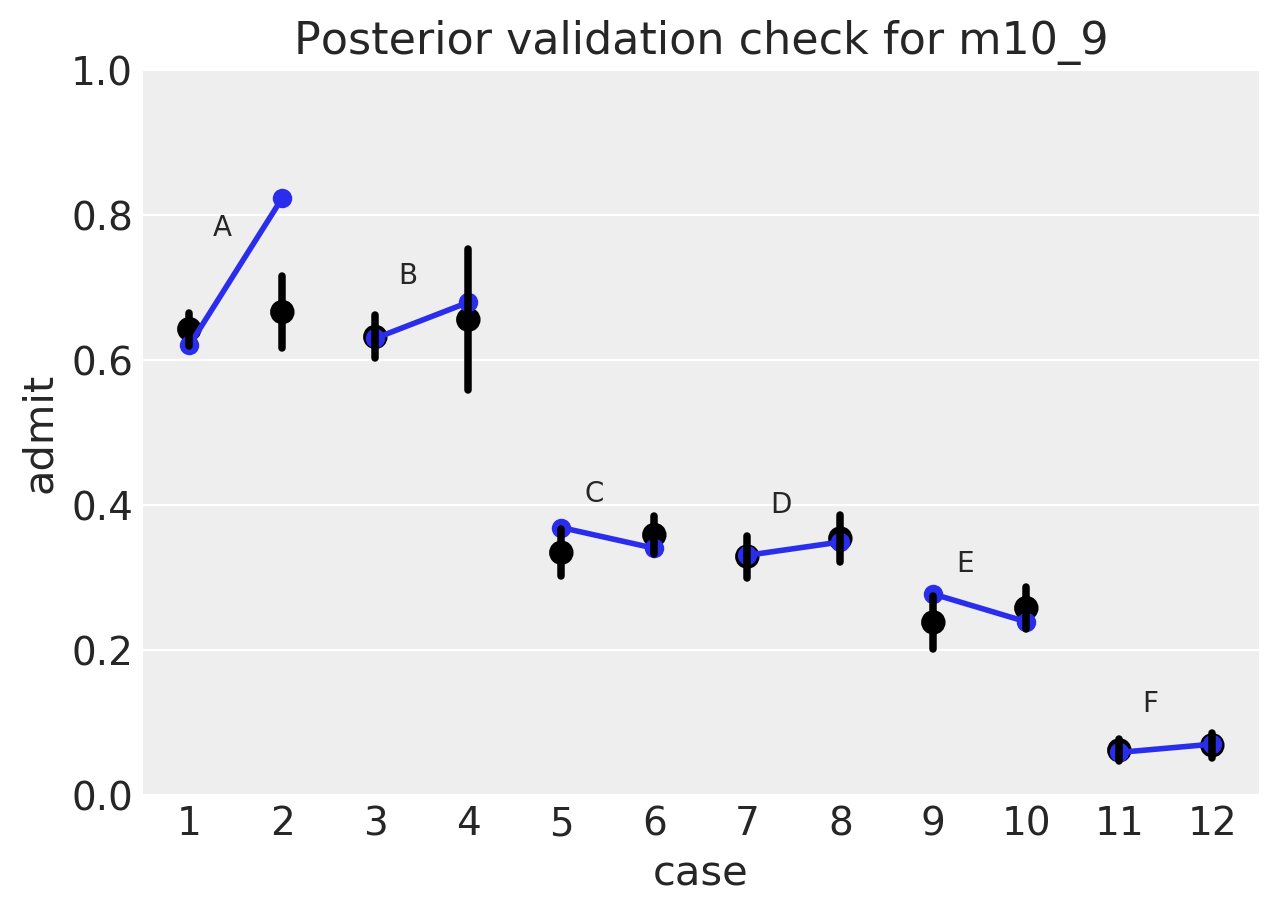

In [35]:
for i in range(6):
    x = 2 * i
    y1 = d.admit[x] / d.applications[x]
    y2 = d.admit[x+1] / d.applications[x+1]
    plt.plot([x, x+1], [y1, y2], '-C0o', lw=2)
    plt.text( x + 0.25, (y1+y2)/2 + 0.05, d.dept[x])


t = pd.DataFrame(pm.sample_posterior_predictive(trace_m10_9, 1000, m10_9)["admit"]).T
x = pd.concat([d, t], axis=1).melt(id_vars=d.columns).assign(value = lambda x: x.value / x.applications)
sns.pointplot(x="index", y="value", data=x, join=False, color='k', ci="sd", fillcolor=None)
plt.ylim(0, 1)
plt.title("Posterior validation check for m10_9")
plt.xlabel("case")
plt.ylabel("admit");

##### Code 10.31

In [36]:
# same as 10.28
with pm.Model() as m10_9s:
    a = pm.Normal('a', mu=0, sd=10, shape=d["dept_id"].nunique())
    bm = pm.Normal('bm', mu=0, sd=10)
    p = pm.math.invlogit(a[d.dept_id] + bm * d.male)
    admit = pm.Binomial('admit', n=d.applications, p=p, observed=d.admit)
    trace_m10_9s = pm.sample(1000, tune=1000)

az.summary(trace_m10_9s, credible_interval=0.89, kind='stats', round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bm, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1196.39draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
a[0],0.68,0.10,0.54,0.85
a[1],0.64,0.12,0.46,0.82
a[2],-0.58,0.08,-0.70,-0.46
a[3],-0.61,0.09,-0.76,-0.48
a[4],-1.06,0.10,-1.23,-0.91
a[5],-2.64,0.16,-2.88,-2.37
bm,-0.10,0.08,-0.24,0.03


##### Code 10.32

In [37]:
import statsmodels.api as sm
from patsy import dmatrix

d["male"] = d["applicant.gender"] == "male"
endog = d.loc[:,['admit', 'reject']].values # cbind(admit,reject)

m10_7glm = sm.GLM(endog, dmatrix('~ 1', data=d), 
                  family=sm.families.Binomial()).fit()
m10_6glm = sm.GLM(endog, dmatrix('~ male', data=d), 
                  family=sm.families.Binomial()).fit()
m10_8glm = sm.GLM(endog, dmatrix('~ dept_id', data=d), 
                  family=sm.families.Binomial()).fit()
m10_9glm = sm.GLM(endog, dmatrix('~ male + dept_id', data=d), 
                  family=sm.families.Binomial()).fit()

# m10_9glm.summary()

##### Code 10.33

In [38]:
import statsmodels.formula.api as smf
d = pd.read_csv("../../data/chimpanzees.csv", sep=";")
d.actor = pd.Categorical(d.actor)
m10_4glm = smf.glm(formula='pulled_left ~ actor + prosoc_left*condition - condition', data=d, 
                   family=sm.families.Binomial()).fit()

In [39]:
m10_4glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            pulled_left   No. Observations:                  504
Model:                            GLM   Df Residuals:                      495
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -256.52
Date:                Sun, 24 May 2020   Deviance:                       513.04
Time:                        15:31:47   Pearson chi2:                     436.
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.7266      0.269     -2.705      0.007      -1.253      -0.200
actor[T.2]               24.9491   1.52e+04      0.002      0.999   -2.97e+04    2.97e+04
actor[T.3]               -0.3050      0.350     -0.871      0.384      -0.991       0.381
actor[T.4]               -0.3050      0.350     -0.871      0.384      -0.991       0.381
actor[T.5]             5.884e-15      0.344   1.71e-14      1.000      -0.674       0.674
actor[T.6]                0.9395      0.349      2.693      0.007       0.256       1.623
actor[T.7]                2.4837      0.451      5.511      0.000       1.600       3.367
prosoc_left               0.8224      0.261      3.147      0.002       0.310       1.335
prosoc_left:condition    -0.1324      0.297     -0.445      0.656      -0.715       0.450
=========================================================================================
"""

##### Code 10.34

In [40]:
pm.GLM.from_formula('pulled_left ~ prosoc_left*condition - condition', 
                    family='binomial', data=d)

##### Code 10.35

In [41]:
y = np.hstack([np.ones(10,)*0, np.ones(10,)])
x = np.hstack([np.ones(9,)*-1, np.ones(11,)])

m_bad = smf.glm(formula='y ~ x', 
                data=pd.DataFrame({'y':y, 'x':x}), 
                family=sm.families.Binomial()).fit()
m_bad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3.3510
Date:                Sun, 24 May 2020   Deviance:                       6.7020
Time:                        15:31:48   Pearson chi2:                     11.0
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.1317   8032.690     -0.001      0.999   -1.58e+04    1.57e+04
x             12.4343   8032.690      0.002      0.999   -1.57e+04    1.58e+04
==============================================================================
"""

##### Code 10.36

In [42]:
with pm.Model() as m_good:
    ab = pm.Normal('ab', 0, 10, shape=2)
    p = pm.math.invlogit(ab[0] + ab[1]*x)
    y_ = pm.Binomial('y_', 1, p, observed=y)
    trace_m_good = pm.sample(1000, tune=1000)
    MAP = pm.find_MAP()
MAP

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ab]
Sampling 2 chains, 7 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1393.27draws/s]
The acceptance probability does not match the target. It is 0.8882442055251525, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
logp = -9.9185, ||grad|| = 7.2889e-05: 100%|██████████| 13/13 [00:00<00:00, 2182.70it/s]  


{'ab': array([-1.72704484,  4.01710522])}

In [43]:
az.summary(trace_m_good)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ab[0],-5.354,4.398,-13.778,0.914,0.313,0.223,197.0,195.0,217.0,218.0,1.01
ab[1],8.132,4.406,1.883,16.073,0.309,0.220,203.0,201.0,220.0,243.0,1.01


##### Code 10.37

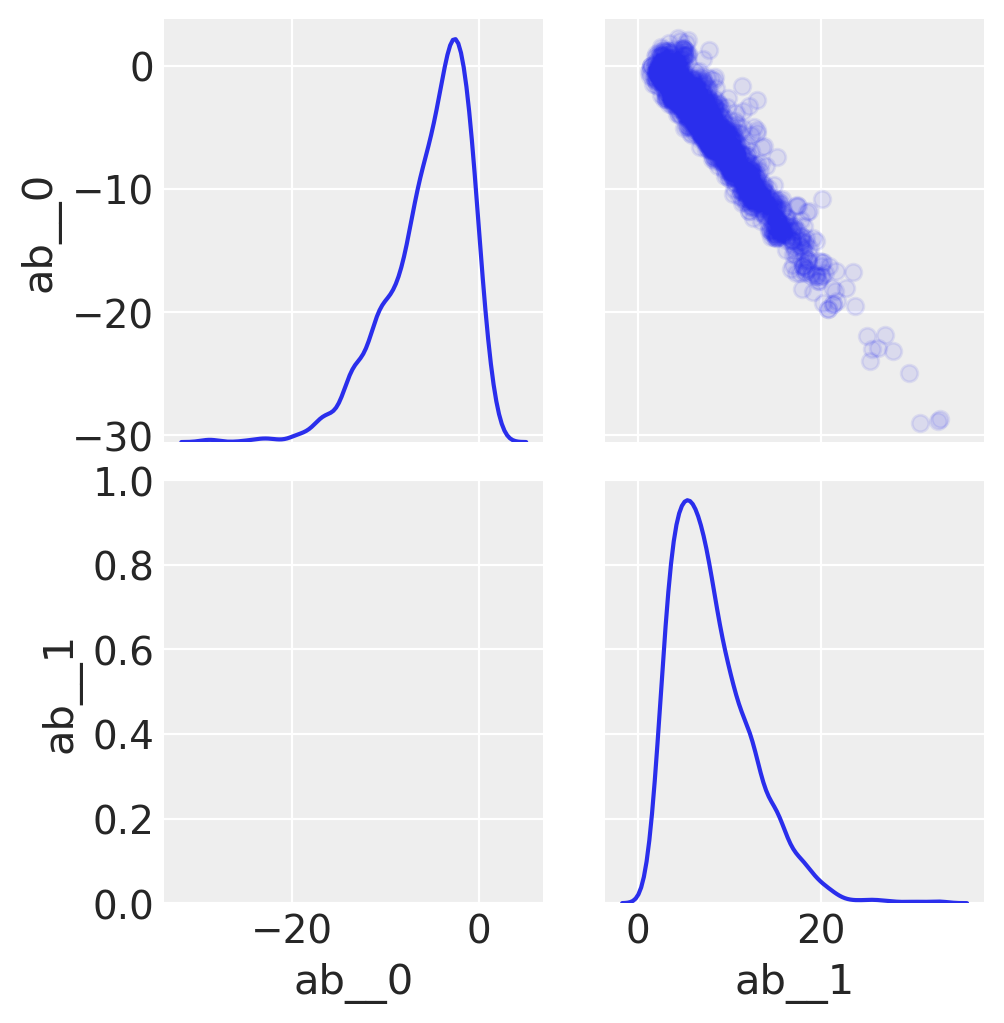

In [44]:
# same as above

tracedf = pm.trace_to_dataframe(trace_m_good)
grid = (sns.PairGrid(tracedf,
                     diag_sharey=False)
           .map_diag(sns.kdeplot)
           .map_upper(plt.scatter, alpha=0.1))

### Poission Regression

##### Code 10.38

In [45]:
y = np.random.binomial(n=1000, p=1/1000, size=100000)
np.mean(y), np.var(y)

(0.99814, 0.9949965404)

##### Code 10.39

In [46]:
dk = pd.read_csv("../../data/Kline.csv", sep=";")
dk

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


##### Code 10.40

In [47]:
dk["log_pop"] = np.log(dk.population)
dk["contact_high"] = np.where(dk.contact == "high", 1 ,0)

In [48]:
from theano import shared
# casting data to theano shared variable. 
# It is for out of sample prediction from model with sampled trace
log_pop = shared(dk.log_pop.values)
contact_high = shared(dk.contact_high.values)
total_tools = shared(dk.total_tools.values)

##### Code 10.41

In [49]:
with pm.Model() as m10_10:
    a = pm.Normal('a', mu=0, sd=100)
    bp = pm.Normal('bp', mu=0, sd=1)
    bc = pm.Normal('bc', mu=0, sd=1)
    bpc = pm.Normal('bpc', mu=0, sd=1)
    lam = pm.math.exp(a + bp * log_pop + bc * contact_high + bpc * log_pop * contact_high)
    obs = pm.Poisson("total_tools", mu=lam, observed=total_tools)
    trace_m10_10 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpc, bc, bp, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 327.08draws/s]


##### Code 10.42

In [50]:
az.summary(trace_m10_10, credible_interval=0.89, round_to=2, kind="stats")

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.93,0.36,0.32,1.47
bp,0.27,0.03,0.21,0.32
bc,-0.05,0.82,-1.37,1.22
bpc,0.04,0.09,-0.11,0.18


In [51]:
trace_10_10.varnames

NameError: name 'trace_10_10' is not defined

In [ ]:
# var-covar matrix
trace_cov = pm.trace_cov(trace_m10_10, model=m10_10)

# 1 / std of each variable
inv_stdD  = 1 / np.sqrt(np.diag(trace_cov))[:, None]

# correlation matrix
pd.DataFrame(inv_stdD*trace_cov*inv_stdD.T, index=trace_m10_10.varnames, columns=trace_m10_10.varnames).round(2)

In [ ]:
az.plot_forest(trace_m10_10, figsize=(8,4));

##### Code 10.43

In [ ]:
post = pm.trace_to_dataframe(trace_m10_10)

lambda_high = np.exp(post.eval("a + bc + (bp + bpc) * 8"))
lambda_low = np.exp(post.eval("a + bp * 8"))

##### Code 10.44

In [ ]:
diff = lambda_high - lambda_low
np.sum(diff > 0) / diff.size

##### Figure 10.8

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

sns.kdeplot(diff, ax=ax1)
ax1.axvline(linestyle="--", color="k")
ax1.set_xlabel("lambda_high - lambda_low")
ax1.set_ylabel("Density")

post.plot(x="bc", y="bpc", kind="scatter", ax=ax2, alpha=0.2);

##### Code 10.45

In [ ]:
with pm.Model() as m10_11:
    a = pm.Normal('a', mu=0, sd=100)
    bp = pm.Normal('bp', mu=0, sd=1)
    bc = pm.Normal('bc', mu=0, sd=1)
    lam = pm.math.exp(a + bp * log_pop + bc * contact_high)
    obs = pm.Poisson("total_tools", mu=lam, observed=total_tools)
    trace_m10_11 = pm.sample(1000, tune=1000)

##### Code 10.46

In [ ]:
with pm.Model() as m10_12:
    a = pm.Normal('a', mu=0, sd=100)
    bp = pm.Normal('bp', mu=0, sd=1)
    lam = pm.math.exp(a + bp * log_pop)
    obs = pm.Poisson("total_tools", mu=lam, observed=total_tools)
    trace_m10_12 = pm.sample(1000, tune=1000)

with pm.Model() as m10_13:
    a = pm.Normal('a', mu=0, sd=100)
    bc = pm.Normal('bc', mu=0, sd=1)
    lam = pm.math.exp(a + bc * contact_high)
    obs = pm.Poisson("total_tools", mu=lam, observed=total_tools)
    trace_m10_13 = pm.sample(1000, tune=1000)

##### Code 10.47

In [ ]:
with pm.Model() as m10_14:
    a = pm.Normal('a', mu=0, sd=100)
    lam = pm.math.exp(a)
    obs = pm.Poisson("total_tools", mu=lam, observed=total_tools)
    trace_m10_14 = pm.sample(1000, tune=1000)

In [ ]:
islands_compare = az.compare({f"m10_{i}": eval(f"trace_m10_{i}") for i in range(10,15)})
islands_compare

In [ ]:
az.plot_compare(islands_compare);

##### Code 10.48

In [ ]:
# set new value for out-of-sample prediction 
log_pop_seq = np.linspace(6, 13, 30)
traces=[eval(f"trace_m10_{i}") for i in [10,11,12]]
models=[eval(f"m10_{i}") for i in [10,11,12]]


log_pop.set_value(np.hstack([log_pop_seq, log_pop_seq]))
c_high = np.hstack([np.repeat(0, 30), np.repeat(1, 30)])
contact_high.set_value(c_high)

islands_ensemble = pm.sample_posterior_predictive_w(traces, 1000, models, weights=islands_compare[:3].weight.sort_index(ascending=True))['total_tools']                                                                                                                       

In [ ]:
idx = dk.contact_high == 1
plt.scatter(dk.log_pop, dk.total_tools, facecolors=np.where(idx,"C0", "none"), edgecolors=np.where(idx, "C0", "k"))

# Plot high contact
az.plot_hpd(log_pop_seq, islands_ensemble[:,30:], credible_interval=0.5)
plt.plot(log_pop_seq, np.median(islands_ensemble[:,30:], axis=0))

# plot low contact
az.plot_hpd(log_pop_seq, islands_ensemble[:,:30], credible_interval=0.5, color="k")
plt.plot(log_pop_seq, np.median(islands_ensemble[:,:30], axis=0), "--", color="k")

plt.xlabel('log-population')
plt.ylabel('total tools')
plt.xlim(6.8, 12.8)
plt.ylim(10, 73);

##### Code 10.49

In [ ]:
with pm.Model() as m10_10s:
    a = pm.Normal('a', mu=0, sd=100)
    bp = pm.Normal('bp', mu=0, sd=1)
    bc = pm.Normal('bc', mu=0, sd=1)
    bpc = pm.Normal('bpc', mu=0, sd=1)
    lam = pm.math.exp(a + bp * dk.log_pop + bc * dk.contact_high + bpc * dk.log_pop * dk.contact_high)
    obs = pm.Poisson("total_tools", mu=lam, observed=total_tools)
    trace_m10_10s = pm.sample(1000, tune=1000)
    
az.summary(trace_m10_10s, kind="stats", credible_interval=0.89)

##### Code 10.50

In [ ]:
dk["log_pop_c"] = dk["log_pop"] - dk["log_pop"].mean()
with pm.Model() as m10_10s_c:
    a = pm.Normal('a', mu=0, sd=100)
    bp = pm.Normal('bp', mu=0, sd=1)
    bc = pm.Normal('bc', mu=0, sd=1)
    bpc = pm.Normal('bpc', mu=0, sd=1)
    lam = pm.math.exp(a + bp * dk.log_pop_c + bc * dk.contact_high + bpc * dk.log_pop_c * dk.contact_high)
    obs = pm.Poisson("total_tools", mu=lam, observed=total_tools)
    trace_m10_10s_c = pm.sample(1000, tune=1000)
    
az.summary(trace_m10_10s_c, kind="stats", credible_interval=0.89)

In [ ]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    marker_size = abs(corr_r) * 10000
    font_size = np.where(np.abs(corr_r) > 0.5, 40, 20)
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)
    

for trace in [trace_m10_10s, trace_m10_10s_c]:
    tracedf = pm.trace_to_dataframe(trace)
    (
        sns.PairGrid(tracedf,diag_sharey=False, height=1.5)
        .map_diag(sns.kdeplot)
        .map_upper(plt.scatter, alpha=0.1)
        .map_lower(corrdot)
    )

##### Code 10.51

In [ ]:
num_days = 30
y = np.random.poisson(1.5, num_days)

##### Code 10.52

In [ ]:
num_weeks = 4
y_new = np.random.poisson(0.5*7, num_weeks)

##### Code 10.53

In [ ]:
y_all = np.hstack([y, y_new])
exposure = np.hstack([np.repeat(1, 30), np.repeat(7, 4)])
monastry = np.hstack([np.repeat(0, 30), np.repeat(1, 4)])
d = pd.DataFrame([y_all, exposure, monastry], index=["y", "days", "monastery"]).T

##### Code 10.54

In [ ]:
# compute offset
d["log_days"] = np.log(d["days"])

# fit the model
with pm.Model() as m10_15:
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=1)
    lam = pm.math.exp(a + b * d["monastery"] + d["log_days"])
    y = pm.Poisson('y', mu=lam, observed=d["y"])
    trace_m10_15 = pm.sample(10000, tune=1000)

##### Code 10.55

In [ ]:
trace_m10_15.add_values(dict(lambda_old=np.exp(trace_m10_15['a']),
                            lambda_new=np.exp(trace_m10_15['a'] + trace_m10_15['b'])))

In [ ]:
az.summary(trace_m10_15, var_names=['lambda_old', 'lambda_new'],
           credible_interval=.89, round_to=2, kind="stats")

### Other Count Regressions

##### Code 10.56

In [ ]:
N = 500
income = np.arange(3) + 1
score = 0.5 * income

softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)

p = softmax(score)

career = np.random.multinomial(1, p, size=N)
career = np.where(career == 1)[1]
career[:11]

##### Code 10.57

In [ ]:
import theano.tensor as tt
with pm.Model() as m10_16:
    b = pm.Normal('b', mu=0, sd=5)
    s2 = pm.Deterministic("s2", b*2)
    s3 = pm.Deterministic("s3", b*3)
    p_ = pm.math.stack([0, s2, s3])
    obs = pm.Categorical('career', p=tt.nnet.softmax(p_), observed=career)
    trace_m10_16 = pm.sample(1000, tune=1000)
    
az.summary(trace_m10_16, credible_interval=0.89, round_to=2, kind="stats")

##### Code 10.58

In [ ]:
N = 500

# simulate family incomes for each individual
family_income = np.random.rand(N)

# assign a unique coefficient for each type of event
b = np.arange(3)-1

p = softmax(score[:, None] + np.outer(b, family_income)).T
career = np.asarray([np.random.multinomial(1, pp) for pp in p])
career = np.where(career==1)[1]
career

In [ ]:
with pm.Model() as m10_17:
    a23 = pm.Normal('a23', 0., 5., shape=2)
    b23 = pm.Normal('b23', 0., 5., shape=2)
    
    s2 = pm.Deterministic("s2", a23[0] + b23[0]*family_income)
    s3 = pm.Deterministic("s3", a23[1] + b23[1]*family_income)
    
    p_ = pm.math.stack([np.zeros(N), s2, s3]).T
    obs = pm.Categorical('career', p=tt.nnet.softmax(p_), observed=career)
    
    trace_m10_17 = pm.sample(1000, tune=2000, cores=2)
    
az.summary(trace_m10_17, credible_interval=.89, round_to=2, kind="stats")

##### Code 10.59

In [ ]:
d = pd.read_csv("../../data/UCBadmit.csv", sep=";")

##### Code 10.60

In [ ]:
with pm.Model() as m10_binom:
    a = pm.Normal('a', 0, 100)
    p = pm.math.invlogit(a)
    admit = pm.Binomial('admit', p=p, n=d.applications, observed=d.admit)
    trace_m10_binom = pm.sample(1000, tune=1000)
    
# Poisson model of overall admission rate and rejection rate
with pm.Model() as m10_pois:
    a = pm.Normal('a', 0, 100, shape=2)
    lam = pm.math.exp(a)
    admit = pm.Poisson('admit', lam[0], observed=d.admit)
    rej = pm.Poisson('rej', lam[1], observed=d.reject)
    trace_m10_pois = pm.sample(1000, tune=1000)

##### Code 10.61

In [ ]:
m_binom = pm.summary(trace_m10_binom)
logistic(m_binom['mean'])

##### Code 10.62

In [ ]:
m_pois = pm.summary(trace_m10_pois)
np.exp(m_pois['mean'][0])/(np.exp(m_pois['mean'][0])+np.exp(m_pois['mean'][1]))

##### Code 10.63

In [ ]:
# simulate
N = 100
x = np.random.rand(N)
y = np.random.geometric(logistic(-1 + 2*x), size=N)

with pm.Model() as m10_18:
    a = pm.Normal('a', 0, 10)
    b = pm.Normal('b', 0, 1)
    p = pm.math.invlogit(a + b*x)
    obs = pm.Geometric('y', p=p, observed=y)
    trace_m10_18 = pm.sample(1000, tune=1000)
az.summary(trace_m10_18, credible_interval=.89, round_to=2)

In [ ]:
import sys, IPython, scipy, matplotlib, platform, statsmodels, arviz
print("""
This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nSeaborn {}\nNumPy {}\nPandas {}\nStatsmodels {}\nMatplotlib {}\nScipy {}\nArviz {}\n
""".format(sys.version[:5], IPython.__version__, pm.__version__, sns.__version__, np.__version__, pd.__version__, statsmodels.__version__, matplotlib.__version__, scipy.__version__, arviz.__version__))
